# Градиентное обучение на примере линейной регрессии

## Исходные данные

Для этого занятия нам понадобится файл `non_linear.csv`

In [1]:
import logging
import os
import sys
import shutil

import numpy as np
from google.colab import drive

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  # гарантируем воспроизводимость

run_env = os.getenv('RUN_ENV', 'COLLAB')
if run_env == 'COLLAB':
  from google.colab import drive
  ROOT_DIR = '/content/drive'
  drive.mount(ROOT_DIR)
  print('Google drive connected')
  root_data_dir = os.path.join(ROOT_DIR, 'MyDrive', 'ml_course_data')
  sys.path.append(os.path.join(ROOT_DIR, 'MyDrive', 'src'))
else:
  root_data_dir = os.getenv('DATA_DIR', '/srv/data')

print(os.listdir(root_data_dir))

if not os.path.exists(root_data_dir):
  raise RuntimeError('Отсутствует директория с данными')
else:
  print('Содержимое директории %s: %s' % (root_data_dir, os.listdir(root_data_dir)))

Mounted at /content/drive
Google drive connected
['nyt-ingredients-snapshot-2015.csv', 'insurance (1).csv', 'non_linear.csv', 'client_segmentation.csv', 'eigen.pkl', 'clustering.pkl', 'boosting_toy_dataset.csv', 'politic_meme.jpg', 'gray_goose.jpg', 'test_dataset.pkl', 'memes', 'optimal_push_time', 'sklearn_data', 'my_little_recsys', 'corpora', 'logs', 'nltk_data', 'recsys_data', 'MNIST', 'hymenoptera_data', 'pet_projects', 'ocr_dataset_sample.csv', 'geo_points.csv.gzip', 'scored_corpus.csv', 'labeled_data_corpus.csv', 'memes_stat_dataset.zip', 'als_model.pkl', 'raw_data.zip', 'json_views.tar.gz', 'test_data.csv', 'sales_timeseries_dataset.csv.gz', 'brand_tweets_valid.csv', 'brand_tweets.csv', 'Health_and_Personal_Care.jsonl.gz', 'models', 'final_dataset.zip', 'ocr_dataset.zip', 'bidmachine_logs.zip', 'meta_Health_and_Personal_Care.jsonl.gz', 'messages.db', 'user_item_views.zip', 'content_catalog.zip', 'ground_truth_dataset.pkl', 'insurance.csv']
Содержимое директории /content/drive/My

Прочитаем `non_linear.csv`

In [2]:
import os

import numpy as np
import pandas as pd

raw_data_file = os.path.join(root_data_dir, 'non_linear.csv')
data = pd.read_csv(raw_data_file, sep=',')

data = data[
            (data.x_train > 1) & (data.x_train < 5)
].copy()
data.head()

,x_train,y_train
5,1.182421,1.860341
6,1.251605,1.878928
7,1.270474,2.430015
8,1.402553,2.327856
9,1.427711,2.203649


Визуализируем данные

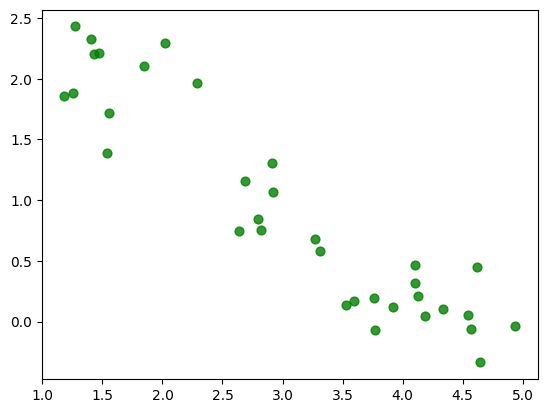

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(
    data.x_train, data.y_train,
    s=40, c='g', marker='o', alpha=0.8
)
plt.show()

Создадим две отдельные переменные

* $y$ для целевой переменной из столбца `y_train`. Удалим из исходного датафрейма с помощью `.drop()`
* Все оставшиеся после удаления столбцы - это матрица объекты-признаки $X$

Для матрицы объекты-признаки добавляем "дефолтный" признак из единиц.

In [4]:
num_examlpes = data.shape[0]
num_features = data.shape[0] - 1  # вычитаем единичку т.к. убрали столбец y
X = np.zeros((num_examlpes, num_features + 1))  # размерность увеличилась на дефолтный столбец


#-------- ВАШ КОД ТУТ -------------------



#-----------------------------------------

Создаём отложенную выборку для валидации - см. предыдущий семинар

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

### Аналитическое решение

Для начала напишем код для аналитического вычисления коэффициентов линейной регрессии по формуле $\overline{w} = \left(X^TX\right)^{-1}X^T\overline{y}$


In [ ]:
from numpy.linalg import inv
import numpy as np

# вычисляем к-ты линейной регрессии
w_analytic = np.zeros(num_features)
#-------- ВАШ КОД ТУТ -------------------



#-----------------------------------------

print(f'Аналитически определённые коэффициенты {w_analytic}')

NameError: ignored

$$
y = x_0*2.98 + x*(-0.67)
$$

Плучите коэффициенты из класса `LinearRegression` - мы уже делали так на прошлом семинаре

In [ ]:
from sklearn.linear_model import LinearRegression
#-------- ВАШ КОД ТУТ -------------------



#----------------------------------------

LinearRegression()

Сравните по евклидовому расстоянию коэффициенты из класса `LinearRegression` и полученные аналитическим способом

In [ ]:
from numpy.linalg import inv, norm

#-------- ВАШ КОД ТУТ -------------------






#----------------------------------------

Проверка на правильность - пишем юнит-тест!

In [ ]:
import unittest


class TestNotebook(unittest.TestCase):
    def test_task(self):
        self.assertAlmostEqual(linalg_norm, 0.000000, places=6)

unittest.main(argv=[''], verbosity=2, exit=False)

# Критика аналитического решения

почему не всегда работает - проверим на примере

В уроке про варидацию столкнулись с ворненгом **LinAlgWarning** что это за ошибка? Почему она возникает? Как её побороть? На эти вопросы даст ответ градиентный спуск - способ обучения моделей, **не использующий матричное умножение**.

## Основные понятия SGD

Мы помним, что в случае многомерной линейной регрессии (когда количество фичей $m$) аналитическое решение имеет вид
$$
\overline{w} = \left(X^TX\right)^{-1}X^T\overline{y}
$$

Где $X$ - т.н. матрица объекты-признаки размености *количество объектов* x *количество признаков*.

У аналитического решения есть ряд недостатков
* вычислительная сложность из-за матричного перемножения $O(n^3)$, где $n$ - размерность матрицы. При увеличении размерности матрицы в 10 раз сложность вычислений увеличивается в $10^3=1000$ раз
* **неустойчивость вычислений** - пытаемся найти обратную матрицу, которая может не существовать, в этом случае в алгоритме нахождения обратной матрицы возникает деление на ноль

С неустойчивостью вычислений, например, связано предупреждение **LinAlgWarning:** которое мы видели в первом уроке. Пример такой матрицы:
$$
X^TX =
\left[
\begin{array}{cc}
5 & 25 \\
2 & 10
\end{array}
\right]
$$

Допустим, хотим вычислить коэффициенты аналитически. Если попытаемся найти обратную матрицу $(X^TX)^{-1}$, мы получим сообщение об ошибке:


In [ ]:
import numpy as np

# матрица из примера
X = np.array([
    [5, 25],
    [2, 10]
])
# пытаемся найти обратную
np.linalg.inv(X)

Это очень печально - значит, мы не всегда можем применять аналитическую формулу $\overline{w} = \left(X^TX\right)^{-1}X^T\overline{y}$ для нахождения коэффициентов $\overline{w}$ Как же быть, если задачу решать все равно надо?

Решение этих проблем нашли математики - давайте вычислять коэффициенты линейной регрессии не аналитически, а с помощью приближённых численных методов. Тогда не надо будет перемножать матрицы или находить обратные матрицы. Самый простой и эффективный из этих методов называется методом *градиентного спуска*. Суть метода состоит в обновлении параметров модели $w$ по маленьким шажкам (вместо того, чтобы находить их сразу) - это и есть градиентный спуск.

Каждый такой шажок назвается "итерация".

Мы знаем, что коэффициенты обучаются при помощи минимизации функции ошибок:

$$
L(y,w) = \sum_{i=1}^{N}\left(y_i - \hat{y_i}\right)^2
$$

Эта функция квадратичная - следовательно, имеет форму параболы. Минимум параболы соответствует минимуму ошибки - давайте как-то понемногу "подкручивать" параметры, чтобы по шажкам спуститься в точку, где ошибка будет минимальной - в этой точке и находятся параметры $w$, которые мы ищем. Правила обновления весов должны быть очень простыми и не содержать матричных перемножений

![grad_descent_single_measure](img/grad_descent_single_measure.png)

В трёхмерном случае картинка более красивая - мы движемся как бы ландшафту и хотим найти самую нижнюю точку на этом ландшафте:

![grad_descent_single_measure](img/grad_descent_multi_measure.png)

В в библиотеке sklearn уже есть класс, в котором реализована логика такого путешествия - это класс `sklearn.linear_model.SGDRegressor`. Давайте посмотрим, как он работает на примере нашей выборки из прошлого урока - начнём с загрузки исходных данных

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# для регрессии
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from scipy.spatial import distance
%matplotlib inline

data = pd.read_csv('data/non_linear.csv', sep=',')
data = data[(data.x_train > 1) & (data.x_train < 5)].copy()

y = data['y_train'].reshape(-1, 1)  # таргет
X = data.drop('y_train', axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

## Градиентный спуск из sklearn

Используем готовую реализацию и функцию [.fit_partial()](https://scikit-learn.org/0.15/modules/scaling_strategies.html#incremental-learning)

Для градиентного спуска мы используем готовый класс [sklearn.linear_model.SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html). Класс принимает следующие параметры

* `learning_rate='constant'` используем самую простую модификацию спуска из нескольких возможных (см. доументацию)
* `eta0=0.009` - шаг градиентного спуска, в формуле мы его обозначали буквой $\eta$
* `fit_intercept=True` - чтобы обучить коэффициент при "свободном члене" $w_0$ линейной регрессии (см. лекцию)
* `random_state=RANDOM_SEED` - этот параметр встречали ранее в этом модуле, он нужен для воспроизводимости вычислений.

Псевдокод решения (нужно закодить самостоятельно, если возникнут сложности - подсмотреть в лекции):

* инициализируем `w_current` рандомом, `weight_evolution` и `rmse_evolution` пустыми списками, и критерий остановки $\varepsilon=0.0001$
* задаём максимальное число шагов `800` и далее на каждом шаге
  * вызываем `.partial_fit`
  * `.coef_` содержит текущие веса - применяем [from scipy.spatial.distance.euclidean](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.euclidean.html#scipy.spatial.distance.euclidean) и сверяем с критерием остановки. Если критерий не выполняется - обновляем rmse с помощью [sklearn.metrics.mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) на `y_valid` и предикт на `X_valid` и переназначаем `w_current` на атрибут `.coef_.copy()`

Когда критерий остановки выполнился - визуализируем `rmse_evolution`, мы должны увидеть т.н. кривую обучения с помощью `.plot(range(step), rmse_evolution)`

Новая библиотека в нашем арсенале  - scipy, изучите её документацию

2022-01-24 17:55:49,213 : INFO : Обучение закончилось
2022-01-24 17:55:49,216 : INFO : Количество пройденных итераций 160


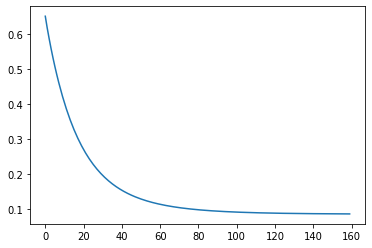

In [ ]:
from sklearn.linear_model import SGDRegressor
from scipy.spatial.distance import euclidean
from sklearn.metrics import mean_squared_error

# можно установить None для эксперимента
rand_state = 42

sgd_regressor = SGDRegressor(
    learning_rate='constant',
    eta0=0.009,
    fit_intercept=True,
    random_state=rand_state
)

# инициализация весов случайным образом
w_current = np.random.random(2)
epsilon = 0.0001

# изменения весов и ошибка на валидации
weight_evolution, rmse_evolution = [], []

for step in list(range(800)):
    # шаг градиентного спуска
    sgd_regressor = sgd_regressor.partial_fit(X_train, y_train)
    # отслеживаем изменения весов
    weight_evolution.append(
        distance.euclidean(w_current, sgd_regressor.coef_)
    )
    # проверяем критерий остановки
    if weight_evolution[-1] < epsilon:
        print("Итарации остановлены на шаге %d" % step); break
    rmse_evolution.append(
        mean_squared_error(y_valid, sgd_regressor.predict(X_valid))
    )
    # обновление весов регрессии
    w_current = sgd_regressor.coef_.copy()
plt.plot(range(step), rmse_evolution)

Визуализируйте решение на графике

Примерный результат который следует ожидать

![fitteg_reg](img/linear_regression_fitted.png)

In [ ]:
x_linspace = np.linspace(data['x_train'].min(), data['x_train'].max(), num=100)

y_linspace= sgd_regressor.predict(x_linspace.reshape(-1,1))

plt.plot(x_linspace, y_linspace)
plt.scatter(data.x_train, data.y_train, 40, 'g', 'o', alpha=0.8, label='data')

plt.show()

**Практическое задание** очевидно, что чем больше шаг градиентного спуска (параметр *eta0* класса *SGDRegressor*), тем быстрее мы придём к оптимальным значениям. Используя под выше, поиграйтесь с параметром *eta0* и добейтесь , чтобы градиентный спуск закончился быстрее, чем за 200 шагов.

Сколько шагов у вас получилось? Какое качество *RMSE* у Вашего решения?

In [ ]:
#-------- ВАШ КОД ТУТ -------------------






#----------------------------------------

Готово! Мы получили решение задачи линейной регрессии, обучив параметры линейной регресии небольшими "шажками". Мы не использовали сложных матричных вычислений - тем не менее получили линию регрессии, которая лежит в середине облака точек. Когда стоит использовать градиентный спуск в реальных задачах?

* когда данных очень много - в этом случае компьютер может не справится с перемножением матриц
* когда нужно контролировать точность обучения - остановить итерации можно в любой момент (не дожидаясь, пока дойдем до "идеальных" значений.

Когда не стоит применять градиентный спуск? Когда данных мало - в этом случае лучше воспользоваться точным решением

**Практическое задание** очевидно, что чем больше шаг градиентного спуска (параметр *eta0* класса *SGDRegressor*), тем быстрее мы придём к оптимальным значениям. Используя под выше, поиграйтесь с параметром *eta0* и добейтесь , чтобы градиентный спуск закончился быстрее, чем за 200 шагов.

Сколько шагов у вас получилось? Какое качество *RMSE* у Вашего решения на валидационной выборке

In [ ]:
#-------- ВАШ КОД ТУТ -------------------






#----------------------------------------

## Реализация GD на python


"Маленькие шажки", которыми мы двигаемся к оптимальному решению в виде формулы выглядят следующим образом:
$$
w^{k+1} = w^k - \eta\nabla L(w)
$$
Переменная $\eta$ в формуле - т.н. *шаг градиентного спуска*.

Где $\nabla L(w)$ - вектор градиента функции. Этот вектор обладает следующими свойствами:

* имеет размерность вектора параметров. Если два параметра $[w_1,w_0]$ - в векторе будет два элемента
* элемент градиента под номером $i$ - это частная производная (вспоминаем математику за 11 класс и [смотрим в Википедию](https://ru.wikipedia.org/wiki/Производная_функции ) ) функции потерь $L(y, w)$ по параметру $w_i$

Вектор антиградиента всегда направлен в сторону уменьшения функции - в этом и есть всё волшебство! Мы будем двигаться в сторону минимума функции ошибки, потому что знаем как туда попасть - надо следовать по антиградиенту.

На картинке одномерный случай. Синяя стрелка - градиент, красная - антиградиент. Видно, что если двигаться по вектору антиградиента, то свалимся в минимум функции за конечное число шагов
![grad_vector](img/grad_vector.png)

Алгоритм визуально выглядит довольно интуитивно - (1) у тебя есть вектор-стрелочка (2) шагай по стрелочке, пока не попадёшь на дно "оврага", который представляет собой целевую функцию . В трёхмерном случае оптимальное значение функции находится в центре концентрицеских эллипсов (эллипс - проекция трёхмерной фигуры функции потерь на плоскость):

![grad_descent](img/grad_descent_intuit.png)

Как туда добраться, двигаясь маленькими шажками?

1. Стартуем алгоритм в случайной начальной точке $x^0$  
1. Вычисляем направление антиградиента $-f'(x^0)$ (буквально: производная со знаком "минус")
1. Перемещаемся по направлению градиента в точку $x^1 = x^0 - \eta f'(x^0)$
1. Повторяем шаги (1-3) для попадания в точку $x^2$
1. $\ldots$
1. Profit! Достигли оптимальной точки $x^*$

Алгоритм выше - универсальный, он позволяет найти точку минимума любой функции $f(x)$. А как же нам найти минимум функции качества линейной регрессии $L$?

$$
L(y,w) = \sum_{i=1}^{N}\left(y_i - \hat{y_i}\right)^2
$$

Чтобы реализовать алгоритм градиентного спуска, выпишем частные прозводные функции качества линейной регрессии $L$ для параметров $\overline{w} = [w_1,\ldots,w_m]$ в простейшем случае $n=1$, то есть для одного обучающего примера (одного наблюдения):
$$
\left\{
\begin{array}{cc}
\frac{\partial L}{\partial w_0} = 2\cdot(-1)\cdot1\cdot (y_1 - (w_0x_0^1 + \ldots+w_mx_m^1)) &\\
\frac{\partial L}{\partial w_k} = 2\cdot(-1)\cdot x_1^1 \cdot (y_1 - (w_0x_0^1 + \ldots+w_mx_m^1)) &  k\neq 0\\
\end{array}
\right.
$$

В формуле все обозначения вам известны

* $w_0, \ldots, w_m$ - коэффициенты линейной регрессиии $m$ - количество фичей
* $x_0, \ldots, x_m$ - фичи.

Эту формулу с частными производными можно легко обобщить на случай, когда в обучающей выборке не один объект, а $n$ - просто добавляем сумму по всем объектам от 1 до $n$:
$$
\left\{
\begin{array}{cc}
\frac{\partial L}{\partial w_0} = \frac{2}{n}\cdot(-1)\cdot \sum_{i=1}^{n} 1\cdot \left(y_i - \sum_{j=1}^{m}w_jx_j^i\right) &\\
\frac{\partial L}{\partial w_k} = \frac{2}{n}\cdot(-1)\cdot \sum_{i=1}^{n} x_k^i \cdot\left(y_i - \sum_{j=1}^{m}w_jx_j^i\right) & k\neq 0 \\
\end{array}
\right.
$$

Что значат переменные в этой формуле?
* $n$ - число точек в обучающей выборке
* $m$ - число фичей в датасете
* $k$ - номер коэффициента в списке параметров линейной регрессии $w = [w_0,\ldots,w_m]$
* $y_i$ - значение целевой переменной на объекте обучающей выборки под номером $i$
* $x_j^i$ - значение фичи под номером $j$ на объекте обучающей выборки под номером $i$


Алгоритм градиентного спуска следующий:

1. Вычислить градиент $\nabla L(w)$
1. Вычислить новый вектор  $w^{k+1} = w^k - \eta\nabla L(w)$
1. Повторять пункты до тех пор, пока $w^{k+1}$ и $w^{k}$ не сойдутся вместе, то есть вектор весов перестанет обновляться

Чтобы лучше понять этот метод, давайте реализуем его "с нуля" на языке Python

In [ ]:
import numpy as np

def gradient(X, y, w, alpha=0) -> np.array:
    """Вычисляем градиент в точке"""
    # количество обучающих примеров в выборке
    n = X.shape[0]
    # считаем прогноз
    y_hat = X.dot(w.T)
    # вычисляем ошибку прогноза
    error = y - y_hat
    # дальше pointwise перемножение - умножаем каждую из координат на ошибку
    pointwise_errors = np.multiply(X, error) + X
    # вычисляем градиент и ошибку
    grad = pointwise_errors.sum(axis=0)*(-1.0)*2.0 / n
    return grad, error

Делаем шаг градиентного спуска

In [ ]:
from scipy.spatial import distance

def eval_w_next(X, y, eta, w_current):
    """Делаем шаг градиентного спуска"""
    # вычисляем градиент
    grad, error = gradient(X, y, w_current)
    # делаем шаг градиентного спуска
    w_next = w_current - eta*grad
    # проверяем условие сходимости
    weight_evolution = distance.euclidean(w_current, w_next)
    return (w_next, weight_evolution, grad)

Повторяем шаги (1,2) до сходимости

In [ ]:
def gradient_descent(X: np.array, y: np.array, eta=0.01, epsilon=0.001) -> np.array:
    m = X.shape[1] # количество фичей
    # инициализируем рандомом веса
    w = np.random.random(m).reshape(1, -1)
    w_next, weight_evolution, grad = eval_w_next(X, y, eta, w)
    step = 0
    # повторяем до сходимости вектора весов
    while weight_evolution > epsilon:
        w = w_next
        w_next, weight_evolution, grad = eval_w_next(X, y, eta, w)
        step += 1
        if step % 100 ==0:
            logger.info("step %s |w-w_next|=%.5f, grad=%s", step, weight_evolution, grad)
    return w

Запускаем обучение

In [ ]:
# трансформируем плоский массив X в вектор-столбец
X = data['x_train'].values.reshape(-1, 1)
n = X.shape[0]
# добавляем тривиальный признак w_0, столбец из единиц. См. прошлый урок, почему так
X = np.hstack([
    np.ones(n).reshape(-1,1),
    X
])
w = gradient_descent(
    X,
    data['y_train'].values.reshape(-1, 1),
    eta=0.008
)

У нас произошло несколько сотен итераций, на каждой итерации мы:
* вычисляем вектор весов
* смотрим расстояние между новым вектором весов и векторов весов с предыдущего шага
* если изменения в векторе весов небольшие (скажем, четвёртый знак поcле запятой) - останавливаем итерации

Когда вектор перестаёт меняться - говорят, что алгоритм "сошёлся" (имеется в виду сходимость к оптимальной точке) - это значит, что итерации можно останавливать.

In [ ]:
support = np.linspace(X.min(), X.max(), num=100)
# делаем предикт - считаем предсказания модели в каждой точке обучающей выборке в виде y=X*w
y_hat = np.hstack([
    np.ones(support.size).reshape(-1, 1),
    support.reshape(-1, 1)
]).dot(w.T)

визуализируем результаты

In [ ]:
# строим график
plt.plot(support, y_hat, 'b--', alpha=0.5, label='manifold')
plt.scatter(data['x_train'], data['y_train'], 40, 'g', 'o', alpha=0.8, label='data')
plt.show()

**Особенности градиентного спуска**

1. Нужно подбирать параметр $\eta$. Еcли выбрать параметр слишком малым, то обучение регрессии будет происходить слишком медленно. Если слишком большим - вычисления не сойдутся к оптимуму. Вариант решения - адаптивный выбор величины шага
1. Долгие вычисления, если размер выборки $n$ становится большим. В этом случае мы можем вычислять градиент не по всей выборке за один шаг, а по одному случайному элементу выборки - в этом случае вычислений значительно меньше.

Кроме того, градиент можно считать не только по одному объекту, но и по случайной подвыборке (батчу). Такая модификация алгоритма называется градиентным спуском по мини-батчам.


Хорошая теория [тут](http://www.machinelearning.ru/wiki/images/6/68/voron-ML-Lin.pdf). Неплохая статья с разбором [формул обновления весов](https://medium.com/@lachlanmiller_52885/machine-learning-week-1-cost-function-gradient-descent-and-univariate-linear-regression-8f5fe69815fd). Видео от [специализации ШАД на coursera](https://ru.coursera.org/lecture/supervised-learning/gradiientnyi-spusk-dlia-linieinoi-rieghriessii-adARX)